# Data Processor and Packager for im2latex Data

This project contains 2 data sources for initial training:
- [im2latex-100k](https://huggingface.co/datasets/yuntian-deng/im2latex-100k) located at `./data/im2latex-100k`
- [im2latex-230k](https://www.kaggle.com/datasets/gregoryeritsyan/im2latex-230k) located at `./data/PRINTED_TEX_230k`

The goal is to combine them into 1 dataset for ease of use.

## Loading the im2latex-230k Dataset

We load the images later when we construct the dataset, as it takes up too much memory and the next few steps do not necessarily require the images to be loaded.

In [22]:
import os
import random
from tqdm import tqdm
from PIL import Image, ImageOps, PngImagePlugin
import matplotlib.pyplot as plt

from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

In [2]:
# Load IM2LATEX-230k dataset
DATA_PATH_IM2LATEX230K = "./data/PRINTED_TEX_230k/"

filenames = []
formulas = []
images = []

with open(os.path.join(DATA_PATH_IM2LATEX230K, "corresponding_png_images.txt")) as file_name_txt:
    filenames = [line.rstrip() for line in file_name_txt]
    
with open(os.path.join(DATA_PATH_IM2LATEX230K, "final_png_formulas.txt")) as formula_txt:
    formulas = [line.rstrip() for line in formula_txt]

In [3]:
# Load im2latex-100k dataset
DATA_PATH_IM2LATEX100K = "./data/im2latex-100k/"

im2latex_100k = load_dataset(DATA_PATH_IM2LATEX100K, trust_remote_code=True)

## Computing Data Overlap

Check for data overlap between the two datasets to prevent data leakage during training.

In [4]:
# Convert formula lists to sets to compute intersection
formula_230k_sets = set(formulas)
formula_100k_train_set = set(im2latex_100k["train"]["formula"])
formula_100k_val_set = set(im2latex_100k["val"]["formula"])
formula_100k_test_set = set(im2latex_100k["test"]["formula"])

train_inter = formula_230k_sets.intersection(formula_100k_train_set)
print(f"230k has {len(train_inter)} overlaps with 100k's training set, which comprises {(len(train_inter) / len(formula_100k_train_set) * 100):.00f}% of 100k's training set")

val_inter = formula_230k_sets.intersection(formula_100k_val_set)
print(f"230k has {len(val_inter)} overlaps with 100k's validation set, which comprises {(len(val_inter) / len(formula_100k_val_set) * 100):.00f}% of 100k's validation set")

test_inter = formula_230k_sets.intersection(formula_100k_test_set)
print(f"230k has {len(test_inter)} overlaps with 100k's testing set, which comprises {(len(test_inter) / len(formula_100k_test_set) * 100):.00f}% of 100k's testing set")

230k has 41690 overlaps with 100k's training set, which comprises 76% of 100k's training set
230k has 4620 overlaps with 100k's validation set, which comprises 76% of 100k's validation set
230k has 5165 overlaps with 100k's testing set, which comprises 76% of 100k's testing set


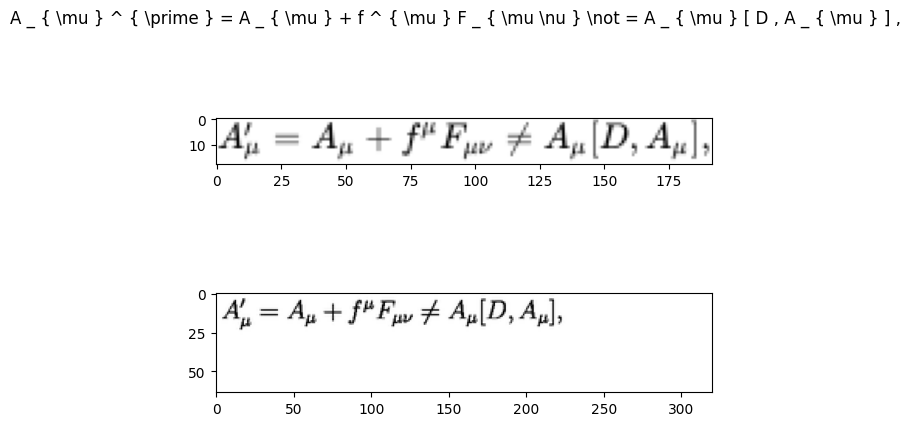

In [5]:
# Overlap example
overlap_example = list(train_inter)[random.randint(0, len(train_inter) - 1)]

overlap_index_230k = formulas.index(overlap_example)
overlap_index_100k = im2latex_100k["train"]["formula"].index(overlap_example)

# Plot figure with images from both datasets
fig = plt.figure()

plt.suptitle(overlap_example)

fig.add_subplot(2, 1, 1)
plt.imshow(Image.open(os.path.join(DATA_PATH_IM2LATEX230K, "generated_png_images", filenames[overlap_index_230k])))
    
fig.add_subplot(2, 1, 2)
plt.imshow(im2latex_100k["train"][overlap_index_100k]["image"])

## Building the Dataset

Build generators for 230k and 100k datasets, cropping the borders from each image for 100k and discarding duplicate cases.

In [6]:
# Initialize empty dataset, with a formula lookup set to maintain efficiency
loaded_formulas = set()

# Generator for final dataset
def im2latex_generator():
    
    # Function to crop white borders
    def crop_borders(img: PngImagePlugin.PngImageFile):
        return img.crop(ImageOps.invert(img).getbbox())
    
    # Generator for 100k dataset
    # We prioritize this one as it tends to have higher quality images
    for split_set in im2latex_100k.keys():
        for expression in tqdm(im2latex_100k[split_set]):
            if not expression["formula"] in loaded_formulas:
                loaded_formulas.add(expression["formula"])
                yield {
                    "formula": expression["formula"],
                    "filename": expression["filename"],
                    "image": crop_borders(expression["image"])
                }
    
    # Generator for 230k dataset
    for (i, formula) in enumerate(tqdm(formulas)):
        if not formula in loaded_formulas:
            loaded_formulas.add(formula)
            yield {
                "formula": formula,
                "filename": filenames[i],
                "image": Image.open(os.path.join(DATA_PATH_IM2LATEX230K, "generated_png_images", filenames[i]))
            }

In [7]:
# Create dataset from generator
im2latex_dataset = Dataset.from_generator(im2latex_generator)

# Create an 8:1:1 training, validation, testing split
train_testvalid = im2latex_dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
im2latex_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']
})

# Verify final dataset size
print(im2latex_dataset['train'].num_rows)
print(im2latex_dataset['val'].num_rows)
print(im2latex_dataset['test'].num_rows)

print(f"final dataset size: {im2latex_dataset['train'].num_rows + im2latex_dataset['val'].num_rows + im2latex_dataset['test'].num_rows}")

100%|██████████| 238329/238329 [00:08<00:00, 27675.45it/s]xamples/s]
Generating train split: 250412 examples [01:31, 2745.41 examples/s] 

200329
25041
25042
final dataset size: 250412


## Final Data Check Inspection and Saving

Check for final dataset for data leakage.
Save the dataset to `./data/im2latex-250k`.

In [8]:
# Convert formula lists to sets to compute intersection
final_train_set = set(im2latex_dataset["train"]["formula"])
final_val_set = set(im2latex_dataset["val"]["formula"])
final_test_set = set(im2latex_dataset["test"]["formula"])

train_inter = final_train_set.intersection(final_val_set)
print(f"the training set has {len(train_inter)} overlaps with the validation set")

val_inter = final_train_set.intersection(final_test_set)
print(f"the training set has {len(val_inter)} overlaps with the testing set")

test_inter = final_val_set.intersection(final_test_set)
print(f"the validation set {len(test_inter)} overlaps the testing set")

the training set has 0 overlaps with the validation set
the training set has 0 overlaps with the testing set
the validation set 0 overlaps the testing set


In [21]:
OUTPUT_DIR = "./data/im2latex-250k/"

# Save dataset to disk
im2latex_dataset.save_to_disk(OUTPUT_DIR)

Saving the dataset (1/1 shards): 100%|██████████| 25041/25041 [00:00<00:00, 41670.93 examples/s]


In [25]:
# Load dataset to check if it has been saved correctly
loaded_im2latex_dataset = load_from_disk(OUTPUT_DIR)

print(loaded_im2latex_dataset)

DatasetDict({
    train: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 200329
    })
    test: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 25042
    })
    val: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 25041
    })
})


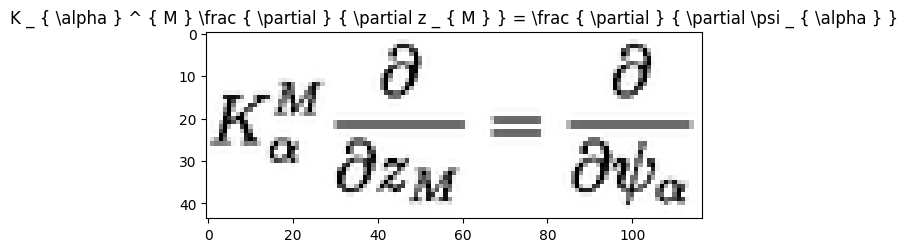

In [37]:
# Overlap example
random_index = random.randint(0, loaded_im2latex_dataset["train"].num_rows - 1)

# Plot formula
plt.title(loaded_im2latex_dataset["train"][random_index]["formula"])
plt.imshow(loaded_im2latex_dataset["train"][random_index]["image"])